## 1. Air quality data preparation
### 1-1. Data extraction

In [33]:
import sys, os
import pandas as pd
sys.path.append("../../../../")

In [34]:
data = pd.read_csv("test_file.csv", parse_dates=True, index_col='time' )

### 1-2. Original Data EDA

in_co2      0
in_humi     0
in_noise    0
in_pm01     0
in_pm10     0
in_pm25     0
in_temp     0
in_voc      0
dtype: int64


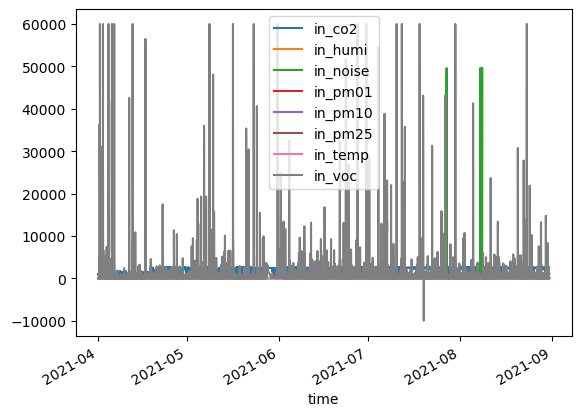

In [35]:
data.plot()
feature_list = data.columns
print(data.isna().sum())

## 2. Data Preprocessing
### 2-1. REFINEMENT
### 

In [36]:
# 1) 기본 REFINEMENT PARAMETER
refine_param = {
   "remove_duplication":{
      "flag":False
   },
   "static_frequency":{
      "flag":False
   }
}
refine_param

{'remove_duplication': {'flag': False}, 'static_frequency': {'flag': False}}

In [37]:
# 2) refinement중 Duplication에 대해 제거하고 싶을 경우
refine_param["remove_duplication"]["flag"]=True
# 3) refinement중 static frequency로 설정하고 싶을 경우
refine_param["static_frequency"]["flag"]=True
refine_param

{'remove_duplication': {'flag': True}, 'static_frequency': {'flag': True}}

In [38]:
# 3-1) Refinement에 대해 특정 frequency를 설정하고 싶을 경우
import datetime 
freq_min = 3
timedelta_frequency_min = datetime.timedelta(minutes= freq_min)
refine_param["static_frequency"]["frequency"]=timedelta_frequency_min
refine_param

{'remove_duplication': {'flag': True},
 'static_frequency': {'flag': True,
  'frequency': datetime.timedelta(seconds=180)}}

In [39]:
# 3-2) Refinement에 대해 Default로 frequency를 설정하고 싶을 경우
refine_param["static_frequency"]["frequency"]=None
refine_param

{'remove_duplication': {'flag': True},
 'static_frequency': {'flag': True, 'frequency': None}}

In [40]:
# 3-3) Parameter에 따른 최종 데이터 처리
from Clust.clust.preprocessing import processing_interface
refine_data = processing_interface.get_data_result('refinement', data , refine_param)

in_co2      6124
in_humi     6124
in_noise    6124
in_pm01     6124
in_pm10     6124
in_pm25     6124
in_temp     6124
in_voc      6124
dtype: int64


<Axes: xlabel='time'>

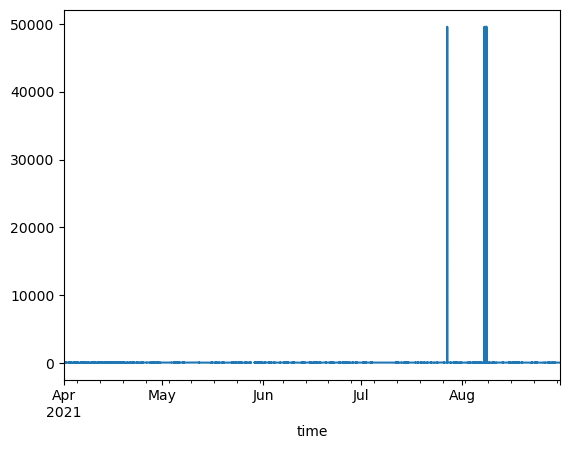

In [41]:
print(refine_data.isna().sum())
refine_data['in_noise'].plot()

### 2-2. Outlier Detection
#### 2-2-1. error_to_NaN

In [42]:
# 1. set outlier_param
certain_param = {'flag': False}
uncertain_param = {'flag': False}
outlier_param = {'certain_error_to_NaN': certain_param,  'uncertain_error_to_NaN': uncertain_param}
outlier_param

{'certain_error_to_NaN': {'flag': False},
 'uncertain_error_to_NaN': {'flag': False}}

In [43]:
# 2) Parameter에 따른 최종 데이터 처리
from Clust.clust.preprocessing import processing_interface
error_to_NaN = processing_interface.get_data_result('error_to_NaN', refine_data , outlier_param)

in_co2      6124
in_humi     6124
in_noise    6124
in_pm01     6124
in_pm10     6124
in_pm25     6124
in_temp     6124
in_voc      6124
dtype: int64


<Axes: xlabel='time'>

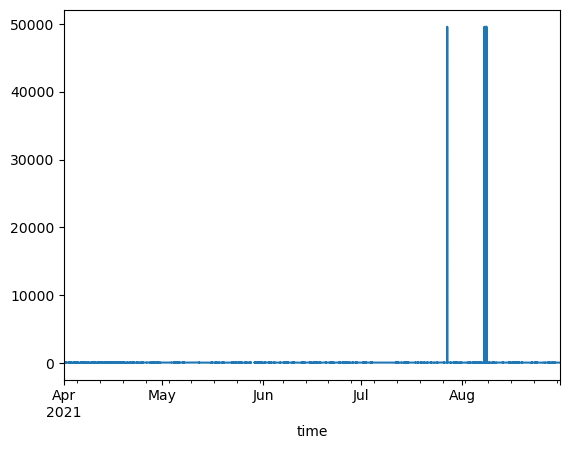

In [44]:
print(error_to_NaN.isna().sum())
error_to_NaN['in_noise'].plot()

#### 2-2-2. Certain Outlier Detection

In [45]:
# 1) Outlier detection을 하기위한 parameter 정의 (min_max={'max_num': {},  'min_num': {}} 가 default)
# 아래 코드는 내부 데이터를 가져오기 위한 파이프라인이므로 무시해도 됩니다.
from Clust.clust.meta.metaDataManager import bucketMeta
from Clust.clust.ingestion.mongo import mongo_client
mongo_client_ = mongo_client.MongoClient(ins.CLUSTMetaInfo2)
min_max = bucketMeta.get_min_max_info_from_bucketMeta(mongo_client_, bucket_name)
"""
#min_max 예제
min_max = {'max_num': {'in_pm01_raw': 1000},  'min_num': {'in_pm01_raw': 0}}
min_max = {'max_num': {},  'min_num': {}}
"""
min_max 

{'max_num': {'in_pm01_raw': 1000,
  'in_pm25_raw': 1000,
  'in_pm10_raw': 1000,
  'in_temp': 80,
  'in_humi': 100,
  'in_co2': 10000,
  'in_voc': 60000,
  'in_noise': 90,
  'in_pm10': 1000,
  'in_pm25': 1000,
  'in_pm01': 1000,
  'in_cici_pm10': 100,
  'in_cici_pm25': 100,
  'in_cici_co2': 100,
  'in_cici_voc': 100,
  'in_cici_temp': 100,
  'in_cici_humi': 100,
  'in_cici_noise': 100,
  'in_cici': 100,
  'in_ciai': 100},
 'min_num': {'in_pm01_raw': 0,
  'in_pm25_raw': 0,
  'in_pm10_raw': 0,
  'in_temp': -40,
  'in_humi': 0,
  'in_co2': 0,
  'in_voc': 0,
  'in_noise': 35,
  'in_pm10': 0,
  'in_pm25': 0,
  'in_pm01': 0,
  'in_cici_pm10': 0,
  'in_cici_pm25': 0,
  'in_cici_co2': 0,
  'in_cici_voc': 0,
  'in_cici_temp': 0,
  'in_cici_humi': 0,
  'in_cici_noise': 0,
  'in_cici': 0,
  'in_ciai': 0}}

In [46]:
# 2) abnormal_value_list가 필요할 경우 
abnormal_value_list =[99.9, 199.9, 299.9, 9999, -99.9, -199.9, -299.9, -9999, -9999.0] 

In [47]:
# 3) Parameter, flag가 False일 경우 처리되지 않으며, 각각의 값이 없을 경우 시스템의 디폴트 값을 가져올 수 있음
certain_param= {'flag': True, "abnormal_value_list":abnormal_value_list, "data_min_max_limit":min_max}
certain_param

{'flag': True,
 'abnormal_value_list': [99.9,
  199.9,
  299.9,
  9999,
  -99.9,
  -199.9,
  -299.9,
  -9999,
  -9999.0],
 'data_min_max_limit': {'max_num': {'in_pm01_raw': 1000,
   'in_pm25_raw': 1000,
   'in_pm10_raw': 1000,
   'in_temp': 80,
   'in_humi': 100,
   'in_co2': 10000,
   'in_voc': 60000,
   'in_noise': 90,
   'in_pm10': 1000,
   'in_pm25': 1000,
   'in_pm01': 1000,
   'in_cici_pm10': 100,
   'in_cici_pm25': 100,
   'in_cici_co2': 100,
   'in_cici_voc': 100,
   'in_cici_temp': 100,
   'in_cici_humi': 100,
   'in_cici_noise': 100,
   'in_cici': 100,
   'in_ciai': 100},
  'min_num': {'in_pm01_raw': 0,
   'in_pm25_raw': 0,
   'in_pm10_raw': 0,
   'in_temp': -40,
   'in_humi': 0,
   'in_co2': 0,
   'in_voc': 0,
   'in_noise': 35,
   'in_pm10': 0,
   'in_pm25': 0,
   'in_pm01': 0,
   'in_cici_pm10': 0,
   'in_cici_pm25': 0,
   'in_cici_co2': 0,
   'in_cici_voc': 0,
   'in_cici_temp': 0,
   'in_cici_humi': 0,
   'in_cici_noise': 0,
   'in_cici': 0,
   'in_ciai': 0}}}

In [48]:
# 4) 명확하게 이상 데이터에 대해서 NaN으로 처리함
more_certain_NaN = processing_interface.get_data_result('certain_error_to_NaN', refine_data, certain_param)

in_co2      6124
in_humi     6124
in_noise    6146
in_pm01     6124
in_pm10     6124
in_pm25     6124
in_temp     6124
in_voc      6125
dtype: int64


<Axes: xlabel='time'>

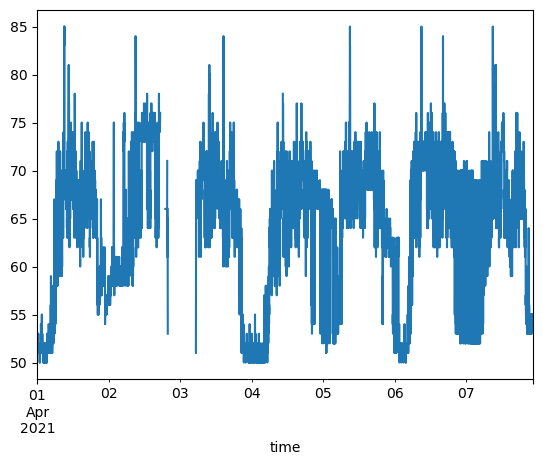

In [49]:
print(more_certain_NaN.isna().sum())
more_certain_NaN['in_noise'][:10000].plot()

<Axes: xlabel='time'>

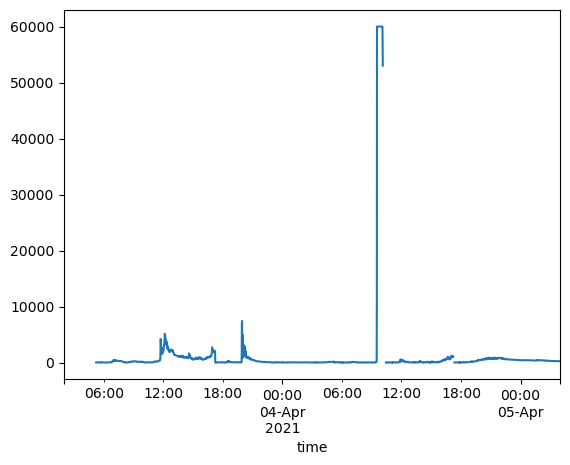

In [50]:
more_certain_NaN['in_voc'][3000:6000].plot()

#### 2-2-3. UnCertain Outlier Detection

In [51]:
# 1) UnCertain Param # uncertain parameter 설정은 다소 복잡함. 추가 예제로 테스트할 수 있으며, 이 테스트 파일에서는 기본 값에 대해 진행
un_certain_param={"flag":True, "param": {'outlierDetectorConfig': [{'algorithm': 'IF',
   'percentile': 99,
   'alg_parameter': {'IF_estimators': 100,
    'IF_max_samples': 'auto',
    'IF_contamination': 0.01,
    'IF_max_features': 1.0,
    'IF_bootstrap': True}}]}}

In [52]:
more_uncertain_nan = processing_interface.get_data_result('uncertain_error_to_NaN', more_certain_NaN, un_certain_param)

100%|█████████████████████████████████████████████| 8/8 [00:51<00:00,  6.49s/it]


in_co2      8229
in_humi     7858
in_noise    8126
in_pm01     8028
in_pm10     8234
in_pm25     8102
in_temp     8040
in_voc      8256
dtype: int64


<Axes: xlabel='time'>

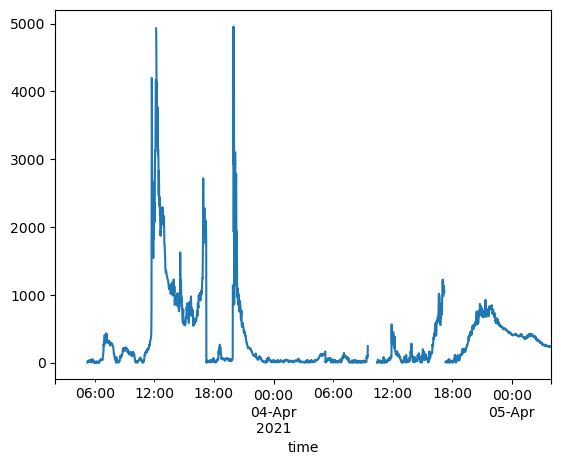

In [53]:
print(more_uncertain_nan.isna().sum())
more_uncertain_nan['in_voc'][3000:6000].plot()

### 2-3. Imputation

In [54]:
imputation_param = {
    "flag":True,
    "imputation_method":[{"min":0,"max":30,"method":"linear", "parameter":{}}, 
                          #{"min":2,"max":3,"method":"brits", "parameter":{"trainDataPathList":[db_name, ms_name]}},
                        {"min":31,"max":100,"method":"KNN", "parameter":{'n_neighbors':10, 'weights':'uniform' , 'metric':'nan_euclidean' }}
    ],
    "total_non_NaN_ratio":80
}

In [55]:
imputed_data= processing_interface.get_data_result('imputation', more_uncertain_nan, imputation_param)

(218880, 8)


in_co2      3904
in_humi     4099
in_noise    3901
in_pm01     4219
in_pm10     5254
in_pm25     4681
in_temp     4080
in_voc      3901
dtype: int64


<Axes: xlabel='time'>

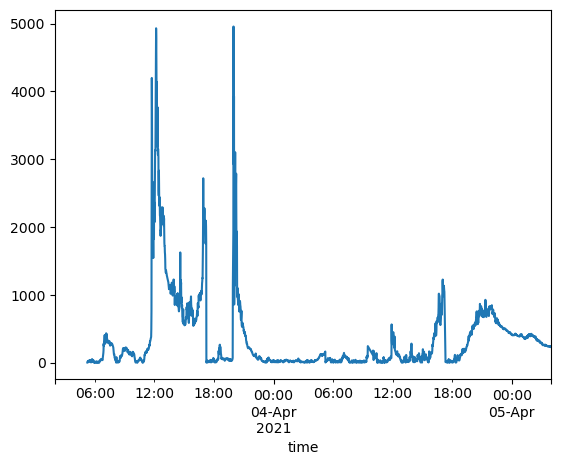

In [56]:
print(imputed_data.isna().sum())
imputed_data['in_voc'][3000:6000].plot()

### 2-4. step3

In [ ]:
process_param = {'refine_param':refine_param, 'outlier_param':outlier_param, 'imputation_param':imputation_param}

from Clust.clust.preprocessing import processing_interface
resultSet = processing_interface.get_data_result('step_3', data, process_param)

(218880, 8)


### 2-5. smoothing

In [ ]:
smoothing_param={'flag': True, 'emw_param':0.3}
smoothing_data= processing_interface.get_data_result('smoothing', imputed_data, smoothing_param)

### 2-6. Scaling

In [ ]:
scaling_param ={'flag': True, 'method':'minmax'} 
scaled_data = processing_interface.get_data_result('scaling', smoothing_data, scaling_param)

In [ ]:
print(scaled_data.isna().sum())
scaled_data.plot()